In [1]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import re
from typing import Union, List

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    

In [4]:
def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [5]:
def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized


In [6]:
def remove_punct(text):
    text = re.sub(r'[^\w\s]', " ", text)
    text = re.sub(' +', ' ', text)
    return text

clean = CleanText()

In [7]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"
    

In [8]:
df = pd.read_csv("rev.csv")

In [9]:
# show column names
print("df.columns: ", df.columns) 

df.columns:  Index(['rating_review', 'review_full'], dtype='object')


In [10]:
# head of df
df.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


In [11]:
# count of ratings
fig = px.histogram(df, x = 'rating_review', title = 'Histogram of Review Rating',
             color = 'rating_review')

fig.update_yaxes(title = 'Count')
fig.show()

In [12]:
df = df.dropna()
df.isnull().sum()
df.reset_index(drop = True, inplace = True)

In [13]:
# basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147579 entries, 0 to 147578
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   rating_review  147579 non-null  int64 
 1   review_full    147579 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [14]:
# encode label and mapping label name
df["label"] = df["rating_review"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [15]:
# clean text, lowercase and remove punk
r = []
for i in range(len(df)):
    r.append(remove_punct(clean(remove_emoji(df['review_full'][i]).lower())[0][0]))
df['Review'] = r

In [16]:
df.head()

,rating_review,review_full,label,label_name,Review
0,5,"Totally in love with the Auro of the place, re...",2,Positive,totally in love with the auro of the place rea...
1,5,I went this bar 8 days regularly with my husba...,2,Positive,i went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...,2,Positive,we were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...,2,Positive,fatjar cafe and market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea...",2,Positive,hey guys if you are craving for pizza and sear...


In [17]:
def plot_wordcloud(data, title = None):
    wordcloud = WordCloud(
        max_words = 200, max_font_size = 40,
        background_color = 'white', random_state = 1).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust()

    plt.imshow(wordcloud)
    plt.show()

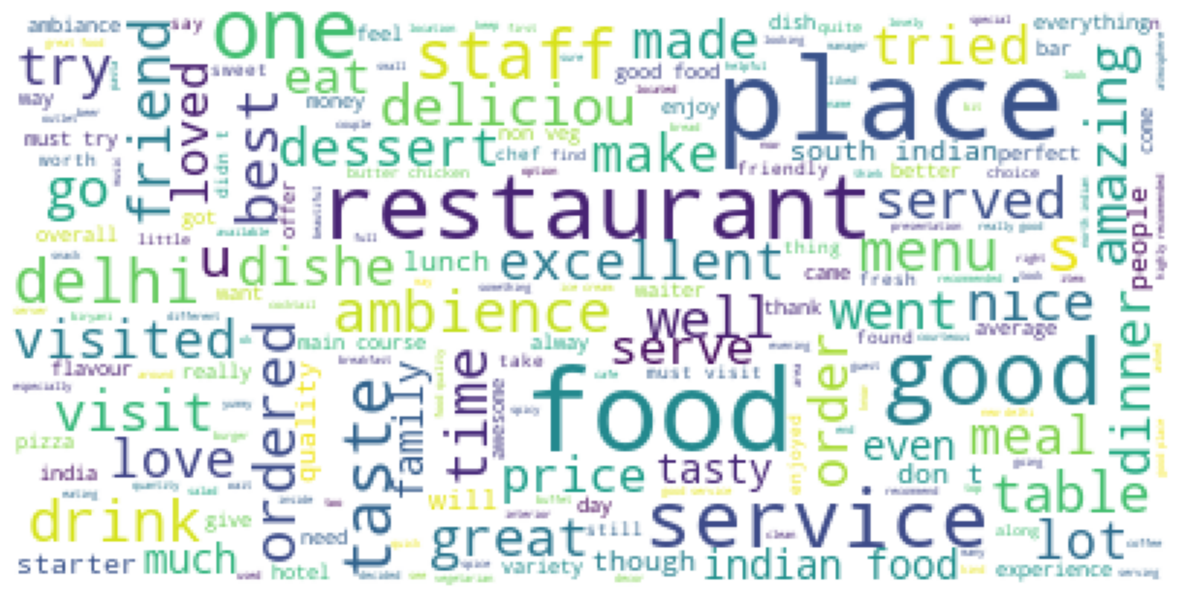

In [18]:
plot_wordcloud(df["Review"].values)

In [19]:
fig = make_subplots(rows = 1, cols = 2, specs = [[{"type": "pie"}, {"type": "bar"}]])
fig.add_trace(go.Pie(labels = df.label_name.value_counts().index,
                             values = df.label.value_counts().values), 1, 1)

fig.add_trace(go.Bar(x = df.label_name.value_counts().index, y = df.label.value_counts().values))
fig.show()

In [20]:
# tokenize data
df["tokenized_review"] = df.Review.apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [21]:
fig = px.histogram(df, x = "sent_token_length", nbins = 20,
                   barmode ='group', histnorm = "percent")
fig.show()

In [22]:
(df.sent_token_length < 512).mean()

0.9938134829481159

In [23]:
!pip install transformers

In [24]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [25]:
# data tokenize with bert tokenizer
df["sent_bert_token_length"] = df["Review"].apply(lambda x: len(tokenizer(x, add_special_tokens = False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


In [26]:
fig = px.histogram(df, x = "sent_token_length", nbins = 20,
                   barmode='group', histnorm="percent")
fig.show()

In [27]:
# Less than 512 covers how many of the data
(df.sent_bert_token_length < 512).mean()


0.9915367362565135

In [28]:
# valvulate char count for each review
df['char_count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout = True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature], hist = True,
                 kde = True, ax = ax1)
    ax1.set(ylabel = 'Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins = 20))


    plt.suptitle(f'{title}', fontsize = 24)

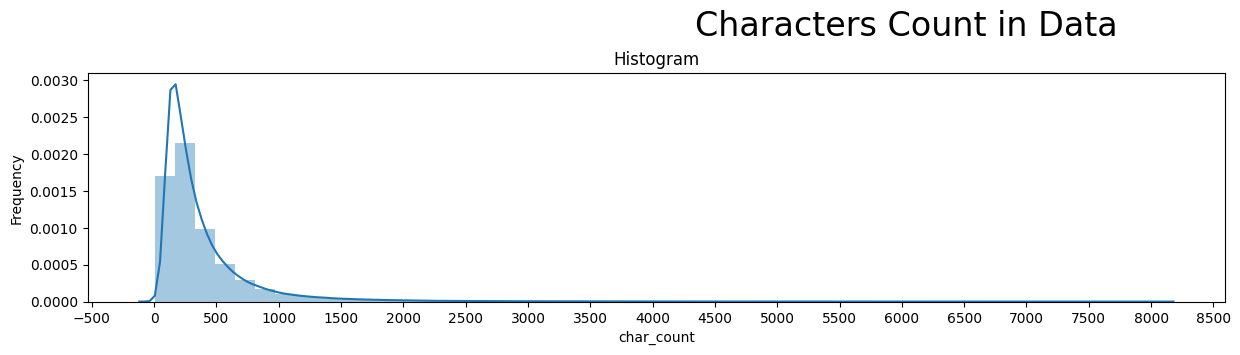

In [29]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

In [30]:
# Creating a new feature for the visualization.
df['Character Count'] = df['Review'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout = True, figsize = (24, 12))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)

    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature], hist = True, kde = True,
                 ax = ax1)
    ax1.set(ylabel = 'Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins = 20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    sns.distplot(df.loc[:, feature], ax = ax2,
                 kde_kws = {'cumulative': True},
                 hist_kws = {'cumulative': True})
    ax2.xaxis.set_major_locator(MaxNLocator(nbins = 20))
    ax2.set(ylabel = 'Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

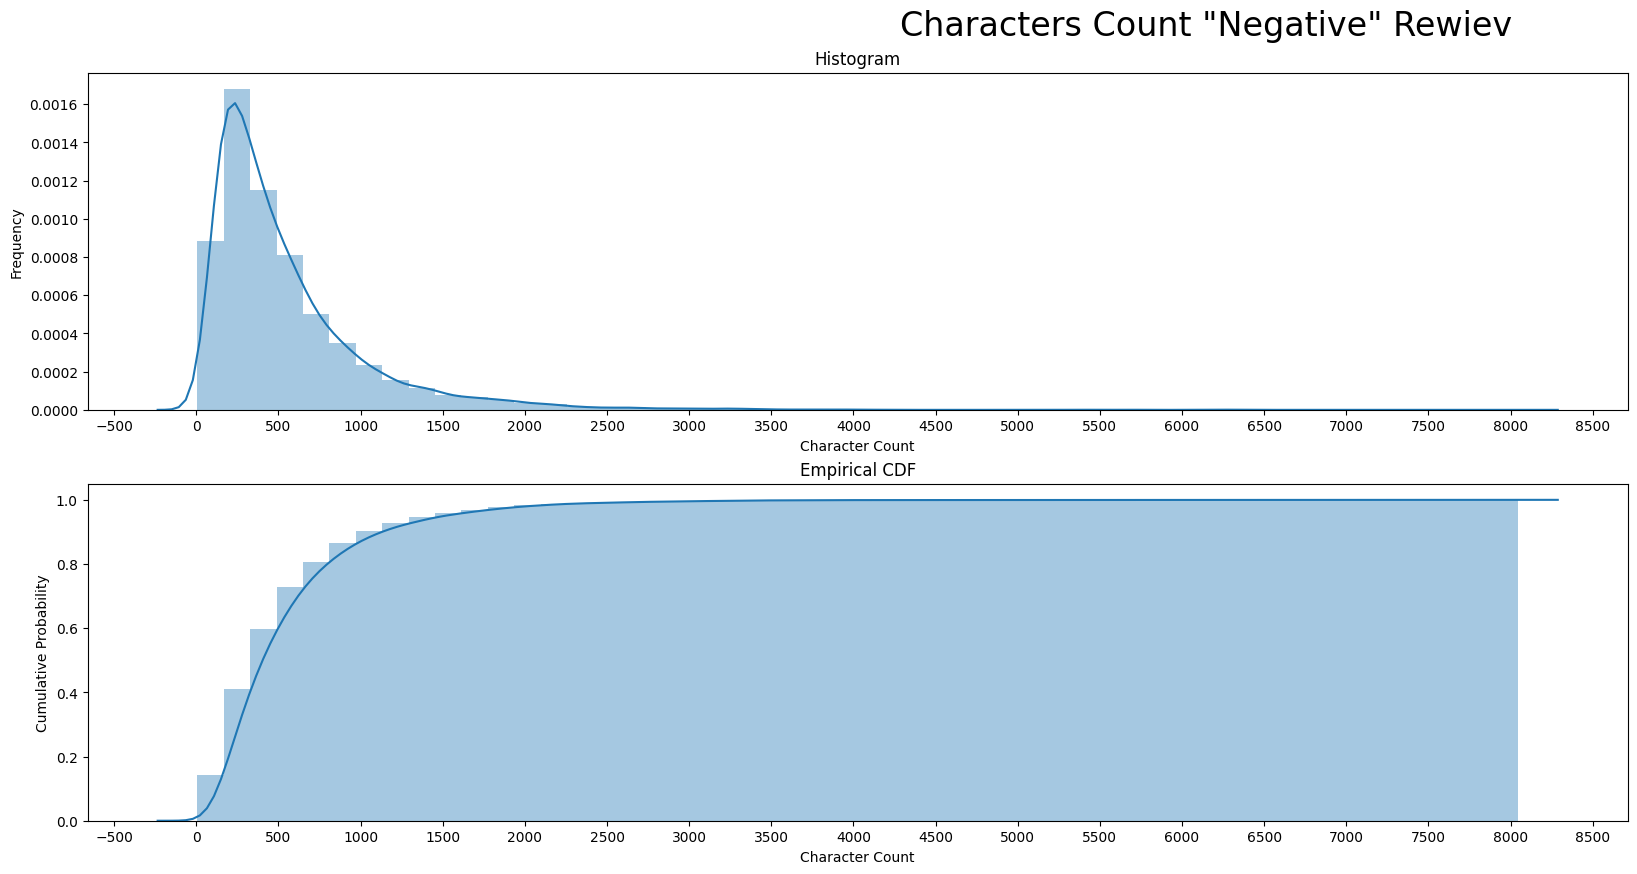

In [31]:
plot_dist3(df[df['label'] == 0], 'Character Count',
           'Characters Count "Negative" Rewiev')

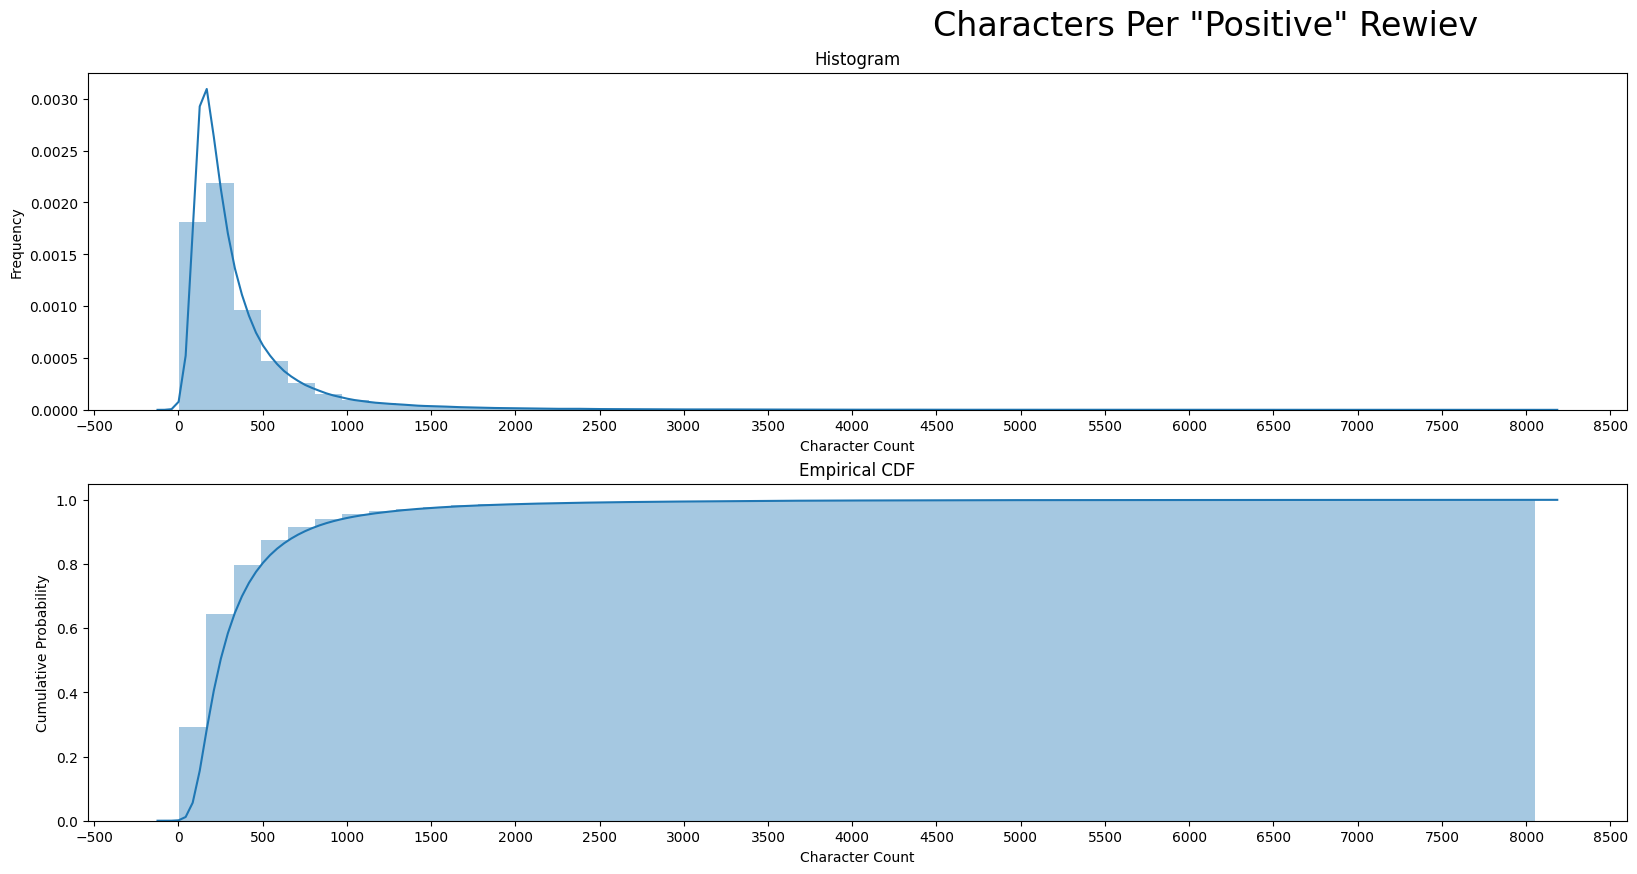

In [32]:
plot_dist3(df[df['label'] == 2], 'Character Count',
           'Characters Per "Positive" Rewiev')

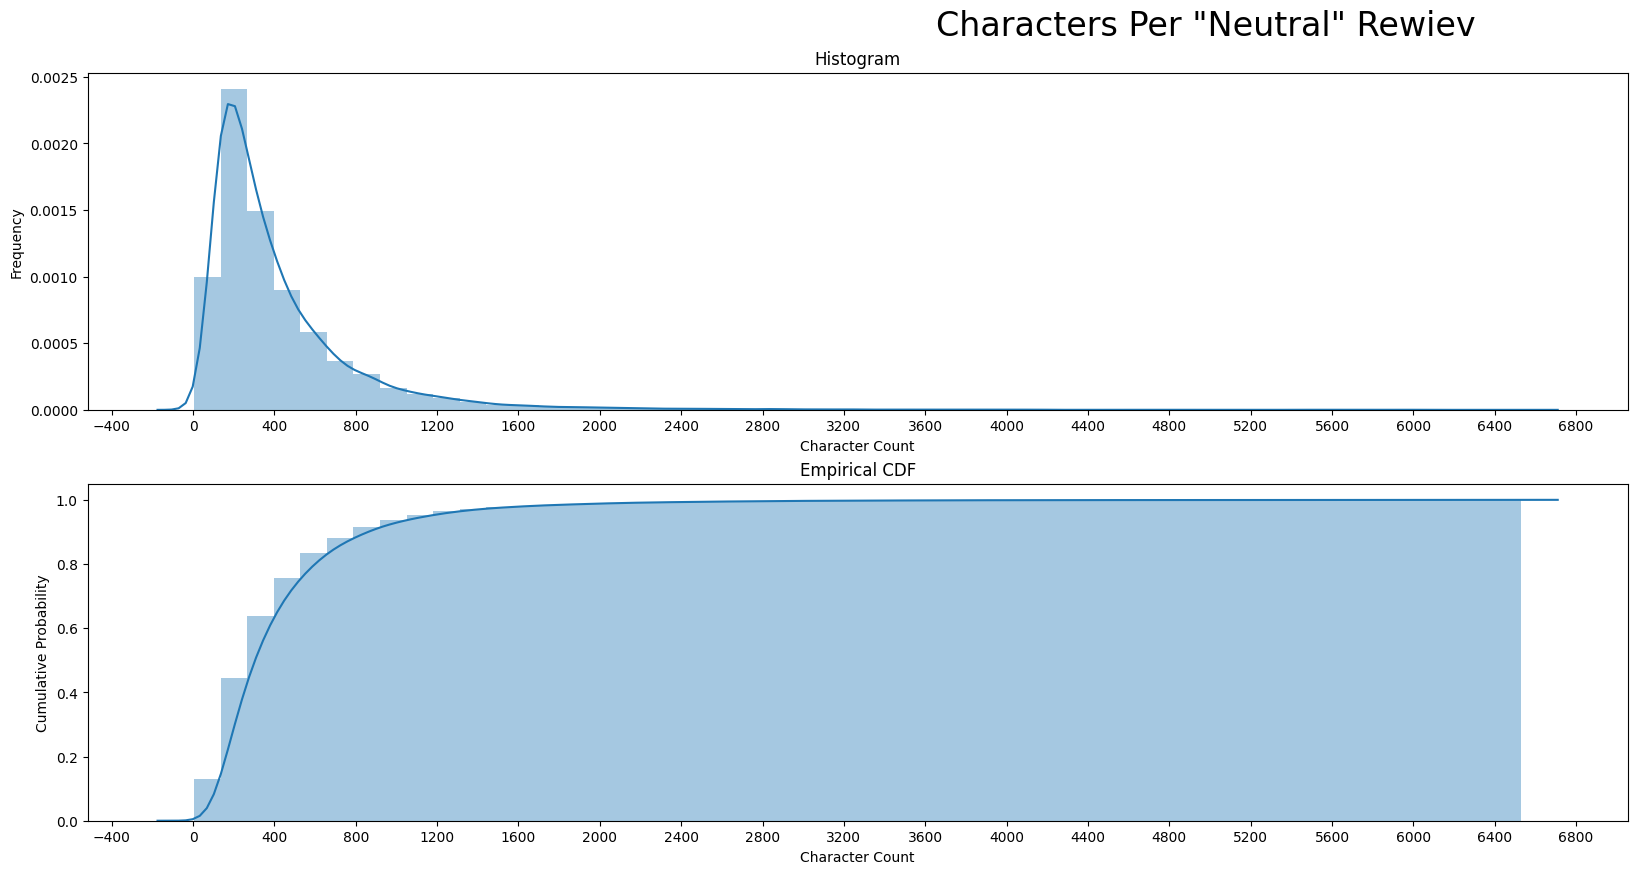

In [33]:
plot_dist3(df[df['label'] == 1], 'Character Count',
           'Characters Per "Neutral" Rewiev')

In [34]:
def plot_word_number_histogram(textno, textye, textz):
    
    fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (18, 12))
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax = axes[0])
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax = axes[1])
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax = axes[2])

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per Review', fontsize = 20)
    
    fig.tight_layout()

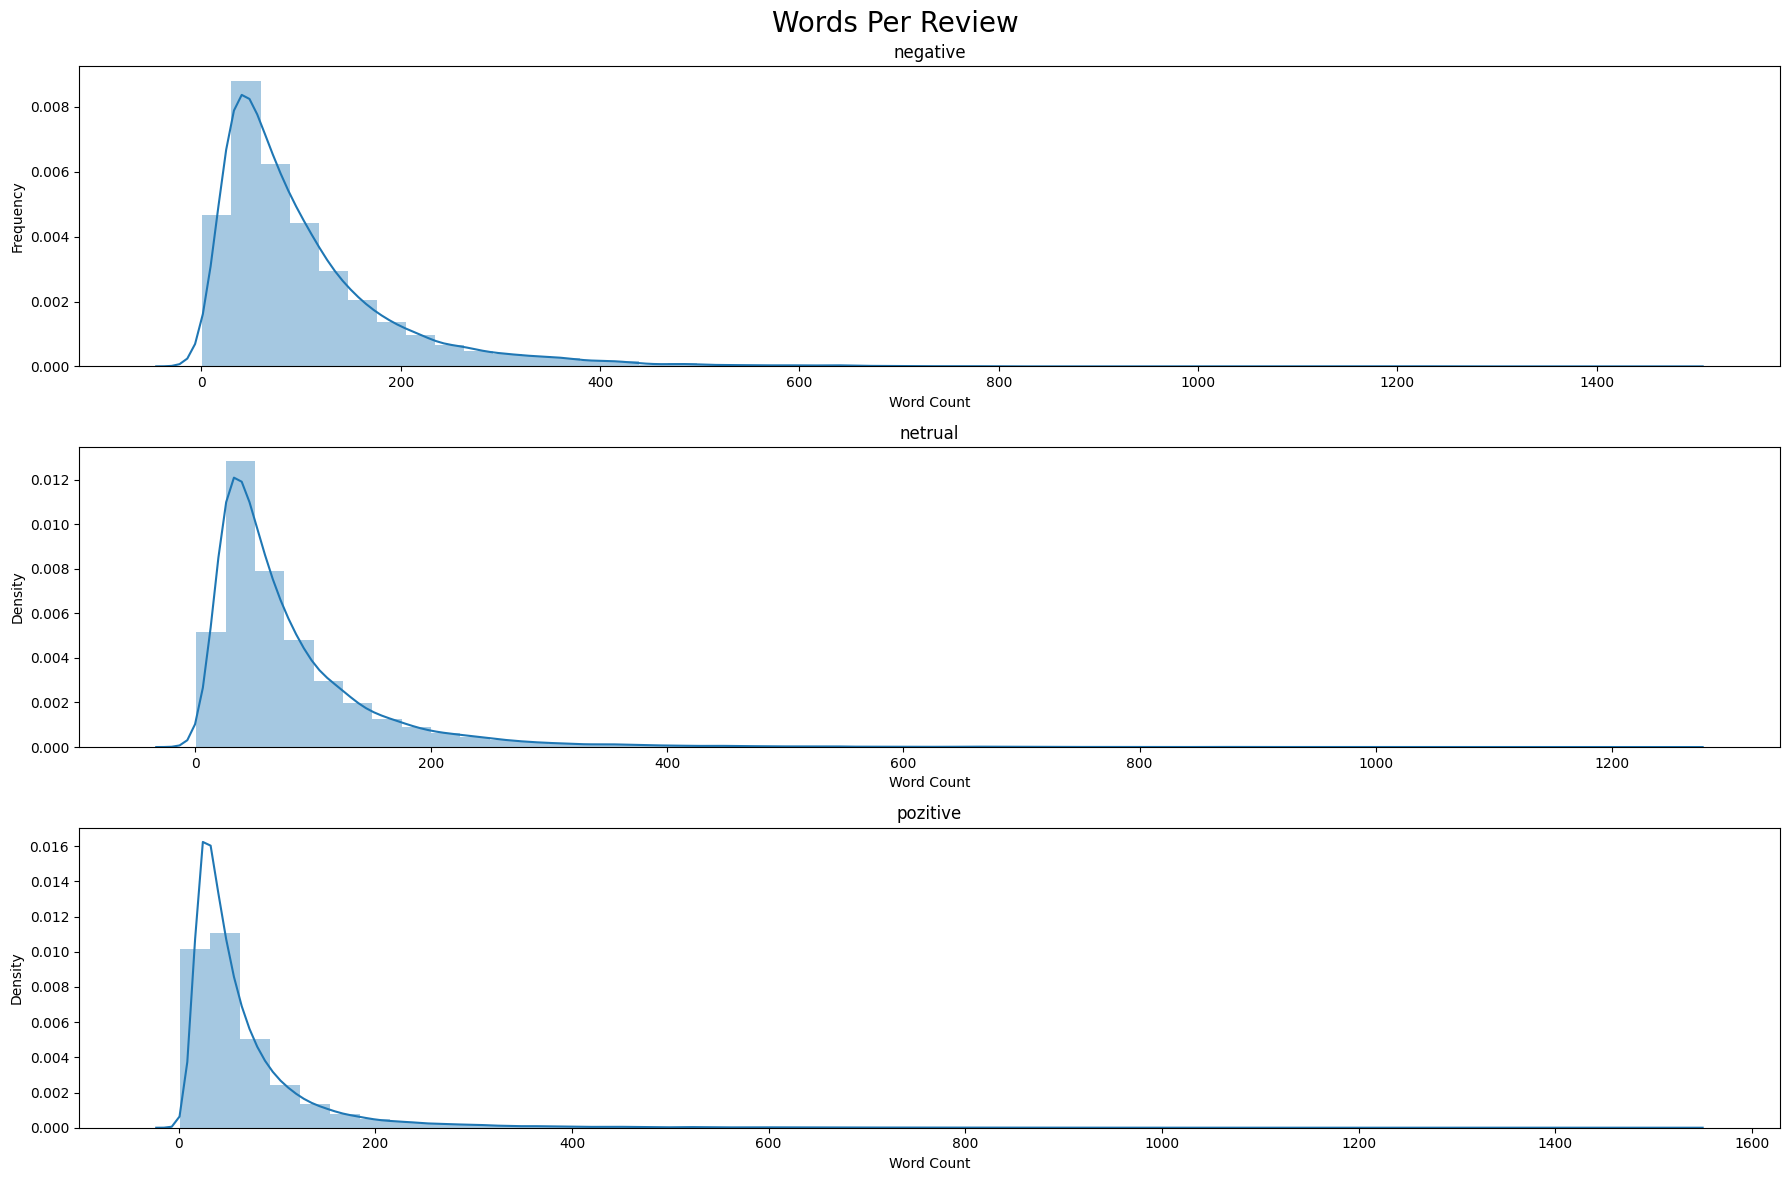

In [35]:
plot_word_number_histogram(df[df['label'] == 0]['Review'],
                           df[df['label'] == 1]['Review'],
                           df[df['label'] == 2]['Review'])

In [36]:
# remove punk 
df['tokenized_review'] = df['tokenized_review'].apply(lambda x: remove_punct(x))

In [37]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)


fig = go.Figure(go.Bar(x = y, y = x, orientation = 'h'))
fig.update_layout( title ={'text': "Most Common Words"})
fig.show()

In [38]:
fig = make_subplots(rows = 1, cols = 3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(x = y, y = x, orientation = 'h', type = "bar", name = title_[i]))
    
fig.update_layout(title = dict(text = 'Most Common ngrams per Classes'))
fig.show()

In [39]:
def _get_top_ngram(corpus, n = None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range = (n, n), max_df = 0.9).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:15]

In [40]:
# unigram
fig = make_subplots(rows = 1, cols = 3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x = y, y = x,
                orientation = 'h', type = "bar", name = title_[i]))
    

fig.update_layout(title = dict(text = 'Most Common unigrams per Classes'))      
fig.show()

In [41]:
#trigram

fig = make_subplots(rows = 1, cols = 3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x = y, y = x,
                orientation = 'h', type = "bar", name = title_[i]))

fig.update_layout(
    title = dict(text = 'Most Common trigrams per Classes'))
fig.show()

We examined and visualized the data, now we can move on to the model building part.

In [42]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [43]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [44]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5 
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size = 0.15
    random_state = 42
    add_special_tokens = True 
    return_attention_mask = True 
    pad_to_max_length = True 
    do_lower_case = False
    return_tensors = 'pt'

config = Config()

In [45]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device" : str(config.device),
    "epochs" : config.epochs, 
    "batch_size" : config.batch_size,
    "seq_length" : config.seq_length,
    "lr" : config.lr,
    "eps" : config.eps,
    "pretrained_model" :  config.pretrained_model,
    "test_size" : config.test_size,
    "random_state" : config.random_state,
    "add_special_tokens" : config.add_special_tokens,
    "return_attention_mask" : config.return_attention_mask,
    "pad_to_max_length" : config.pad_to_max_length,
    "do_lower_case" : config.do_lower_case,
    "return_tensors" : config.return_tensors,
         }

In [46]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [47]:
df.head()

,rating_review,review_full,label,label_name,Review,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
0,5,"Totally in love with the Auro of the place, re...",2,Positive,totally in love with the auro of the place rea...,totally in love with the auro of the place rea...,126,150,713,713
1,5,I went this bar 8 days regularly with my husba...,2,Positive,i went this bar 8 days regularly with my husba...,i went this bar 8 days regularly with my husba...,35,37,192,192
2,5,We were few friends and was a birthday celebra...,2,Positive,we were few friends and was a birthday celebra...,we were few friends and was a birthday celebra...,28,30,142,142
3,5,Fatjar Cafe and Market is the perfect place fo...,2,Positive,fatjar cafe and market is the perfect place fo...,fatjar cafe and market is the perfect place fo...,81,87,431,431
4,5,"Hey Guys, if you are craving for pizza and sea...",2,Positive,hey guys if you are craving for pizza and sear...,hey guys if you are craving for pizza and sear...,99,110,521,521


In [48]:
#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(df, 
                                    test_size=0.10, 
                                    random_state=config.random_state, 
                            stratify=df.label.values)

In [49]:
train_df_.head()

,rating_review,review_full,label,label_name,Review,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
70943,4,When looking for a place to have lunch on a Su...,2,Positive,when looking for a place to have lunch on a su...,when looking for a place to have lunch on a su...,115,132,593,593
114313,5,I visited Novotel's Food Exchange with my fami...,2,Positive,i visited novotel s food exchange with my fami...,i visited novotel s food exchange with my fami...,165,178,890,890
75957,4,Yes its true... Great ambience and good qualit...,2,Positive,yes its true great ambience and good quality f...,yes its true great ambience and good quality f...,44,48,227,227
119409,4,The ambience is hospitable and flowing with en...,2,Positive,the ambience is hospitable and flowing with en...,the ambience is hospitable and flowing with en...,48,55,276,276
109261,5,"Everything is perfect in this place, the ambie...",2,Positive,everything is perfect in this place the ambien...,everything is perfect in this place the ambien...,69,74,387,387


In [50]:
train_df, test_df = train_test_split(train_df_, 
                                    test_size=0.10, 
                                    random_state=42, 
                            stratify=train_df_.label.values)

In [51]:
# count of unique label  control 
print(len(train_df['label'].unique()))
print(train_df.shape)

3
(119538, 10)


In [52]:
# count of unique label  control 
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(14758, 10)


In [53]:
print(len(test_df['label'].unique()))
print(test_df.shape)

3
(13283, 10)


In [54]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, 
                                          do_lower_case=config.do_lower_case)

In [55]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Review.values, 
    add_special_tokens = config.add_special_tokens, 
    return_attention_mask = config.return_attention_mask, 
    pad_to_max_length = config.pad_to_max_length, 
    max_length = config.seq_length, 
    return_tensors = config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Review.values, 
    add_special_tokens = config.add_special_tokens, 
    return_attention_mask = config.return_attention_mask, 
    pad_to_max_length = config.pad_to_max_length,
    max_length = config.seq_length, 
    return_tensors = config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [56]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [57]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [58]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels = 3,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [59]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler = RandomSampler(dataset_train), 
                              batch_size = config.batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler = SequentialSampler(dataset_val), 
                                   batch_size = config.batch_size)

In [60]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = config.lr, 
                  eps = config.eps)
                  

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(dataloader_train)*config.epochs)

In [61]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')

In [62]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(config.device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [63]:
config.device

device(type='cuda', index=0)

In [64]:
model.to(config.device)
    
for epoch in tqdm(range(1, config.epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    # allows you to see the progress of the training 
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave = False, disable = False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(config.device) for b in batch)
        
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    
    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs 
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/19923 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.32851486322258017
Validation loss: 0.3076098471910246
F1 Score (Weighted): 0.9049606212507989


Epoch 2:   0%|          | 0/19923 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.27991718334242643
Validation loss: 0.3608889879499812
F1 Score (Weighted): 0.9022386503776286


Epoch 3:   0%|          | 0/19923 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.22776059297667653
Validation loss: 0.43309137817361953
F1 Score (Weighted): 0.9006403804496178


Epoch 4:   0%|          | 0/19923 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1563993731328575
Validation loss: 0.563616968217353
F1 Score (Weighted): 0.8992894864111082


Epoch 5:   0%|          | 0/19923 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0944784874928215
Validation loss: 0.6351996504376562
F1 Score (Weighted): 0.8973171714133128


In [65]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       843
           1       0.50      0.58      0.54      1387
           2       0.97      0.95      0.96     12528

    accuracy                           0.90     14758
   macro avg       0.73      0.76      0.74     14758
weighted avg       0.91      0.90      0.90     14758



In [67]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/14758 [00:00<?, ?it/s]

In [68]:
# add pred into val_df
val_df["pred"] = pred_final

In [69]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [70]:
# filtering false predictions
val_df = val_df[val_df.control == False]

In [71]:
# buraları düzenle bbaaaabbaaaaa
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [72]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [73]:
confmat

array([[  0, 139,  54],
       [236,   0, 609],
       [ 39, 315,   0]])

In [74]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Neutral,Positive
row_0,,,
Negative,0,139,54
Neutral,236,0,609
Positive,39,315,0


In [75]:
# save confissuan matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

In [76]:
test_df.head()

,rating_review,review_full,label,label_name,Review,tokenized_review,sent_token_length,sent_bert_token_length,char_count,Character Count
65281,3,Recently visited with a group of my friends. H...,1,Neutral,recently visited with a group of my friends ha...,recently visited with a group of my friends ha...,81,81,410,410
120575,5,I discovered this place last year in GTB Nagar...,2,Positive,i discovered this place last year in gtb nagar...,i discovered this place last year in gtb nagar...,63,71,339,339
23085,5,I have been eating at this outlet since past m...,2,Positive,i have been eating at this outlet since past m...,i have been eating at this outlet since past m...,45,45,205,205
97350,5,You will enjoy your indian food with best of t...,2,Positive,you will enjoy your indian food with best of t...,you will enjoy your indian food with best of t...,20,21,111,111
100553,4,Very good food and restaurant has kept the foo...,2,Positive,very good food and restaurant has kept the foo...,very good food and restaurant has kept the foo...,36,36,195,195


In [77]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Review.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

In [78]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)

In [79]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)
# accuracy_per_class(predictions, true_vals, intent2label)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [80]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       983
           1       0.47      0.62      0.54      1202
           2       0.97      0.95      0.96     12573

    accuracy                           0.91     14758
   macro avg       0.74      0.76      0.75     14758
weighted avg       0.92      0.91      0.91     14758



In [81]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/13283 [00:00<?, ?it/s]

In [82]:
# add pred into test
test_df["pred"] = pred_final

In [83]:
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label.values
test_df["control"] = control

In [84]:
# filtering false predictions
test_df = test_df[test_df.control == False]

In [85]:
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [86]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [87]:
confmat

array([[  0, 133,  39],
       [222,   0, 554],
       [ 35, 298,   0]])

In [88]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test

col_0,Negative,Neutral,Positive
row_0,,,
Negative,0,133,39
Neutral,222,0,554
Positive,35,298,0
